# 1. Install Dependencies and Setup

In [1]:
print("Hello, world!")

Hello, world!


In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
#from keras import backend as k
from keras import backend as k

In [3]:
# set hyperprameters and top-level variables
data_dir = 'data2'
imgsize = 750
batchsize = 32
epochs = 7
learning_rate = 1e-03
epsilon = 1e-08

In [4]:
# # Hide the GPU - forces CPU training
# tf.config.set_visible_devices([], 'GPU')

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
   tf.config.experimental.set_memory_growth(gpu, True)
   #tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 3. Load and Scale Data

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=batchsize, image_size=(imgsize, imgsize))

Found 4671 files belonging to 2 classes.


In [8]:
data = data.map(lambda x,y: (x/255, y))

# 4. Split Data

In [9]:
len(data)

146

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
print("Train size: ", train_size)
print("Val size: ", val_size)
print("Test size: ", test_size)
print("Total size: ", train_size+val_size+test_size)

Train size:  102
Val size:  29
Test size:  14
Total size:  145


In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
# for images, labels in train.take(1):  # only take first element of dataset
#     numpy_images = images.numpy()
#     numpy_labels = labels.numpy()

In [14]:
# numpy_images*255

In [15]:
# index=32
# plt.imshow(numpy_images[index])
# plt.xlabel(numpy_labels[index])
# plt.show()

# 5. Build Deep Learning Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [17]:
# function to determine rough model memory requirements
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([k.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([k.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if k.floatx() == 'float16':
        number_size = 2.0
    if k.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(32, (5,5), 1, activation='relu', input_shape=(imgsize,imgsize,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# model.add(Conv2D(256, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# 
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
# optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 746, 746, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 373, 373, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 371, 371, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 185, 185, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 183, 183, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 91, 91, 32)       0

In [22]:
# limit around 6GB???
get_model_memory_usage(batchsize, model)

4.007

# 6. Train

In [23]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
hist = model.fit(train, epochs=epochs, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/7
102/102 [==============================] - 37s 320ms/step - loss: 0.5370 - accuracy: 0.8686 - val_loss: 0.3029 - val_accuracy: 0.8696
Epoch 2/7
102/102 [==============================] - 34s 326ms/step - loss: 0.2260 - accuracy: 0.9243 - val_loss: 0.2109 - val_accuracy: 0.9246
Epoch 3/7
102/102 [==============================] - 35s 334ms/step - loss: 0.1184 - accuracy: 0.9599 - val_loss: 0.1862 - val_accuracy: 0.9256
Epoch 4/7
102/102 [==============================] - 38s 371ms/step - loss: 0.0645 - accuracy: 0.9789 - val_loss: 0.2580 - val_accuracy: 0.9300
Epoch 5/7
102/102 [==============================] - 39s 372ms/step - loss: 0.0271 - accuracy: 0.9902 - val_loss: 0.2410 - val_accuracy: 0.9364
Epoch 6/7
102/102 [==============================] - 39s 379ms/step - loss: 0.0117 - accuracy: 0.9979 - val_loss: 0.2654 - val_accuracy: 0.9440
Epoch 7/7
102/102 [==============================] - 41s 395ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.2620 - val_accuracy:

# 7. Plot Performance

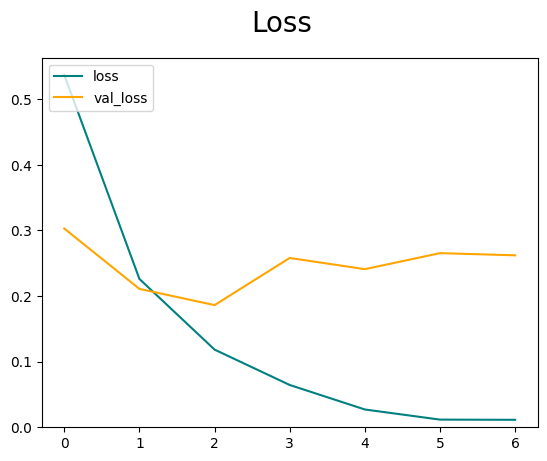

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.ylim(bottom=0)
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

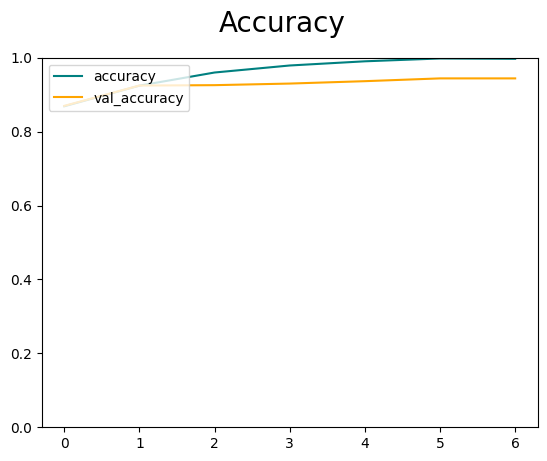

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.ylim(0, 1)
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [31]:
print("-----------------------------------------------------")
print("Precision:       ", pre.result())
print("Recall:          ", re.result())
print("Binary Accuracy: ", acc.result())
print("-----------------------------------------------------")

-----------------------------------------------------
Precision:        tf.Tensor(0.80701756, shape=(), dtype=float32)
Recall:           tf.Tensor(0.5822785, shape=(), dtype=float32)
Binary Accuracy:  tf.Tensor(0.90178573, shape=(), dtype=float32)
-----------------------------------------------------


# 9. Test

In [32]:
img01 = cv2.imread(data_dir + '/_000/_0-01.jpg')
img02 = cv2.imread(data_dir + '/_000/_0-02.jpg')
img03 = cv2.imread(data_dir + '/_000/_0-03.jpg')
img04 = cv2.imread(data_dir + '/_000/_0-04.jpg')
img05 = cv2.imread(data_dir + '/_000/_0-05.jpg')

img11 = cv2.imread(data_dir + '/_FAPT/_F-01.jpg')
img12 = cv2.imread(data_dir + '/_FAPT/_F-02.jpg')
img13 = cv2.imread(data_dir + '/_FAPT/_F-03.jpg')
img14 = cv2.imread(data_dir + '/_FAPT/_F-04.jpg')
img15 = cv2.imread(data_dir + '/_FAPT/_F-05.jpg')

imgT01 = cv2.imread('test/_T-01.jpg')
imgT02 = cv2.imread('test/_T-02.jpg')
imgT13 = cv2.imread('test/_T-03.jpg')
imgT14 = cv2.imread('test/_T-04.jpg')
imgT15 = cv2.imread('test/_T-05.jpg')

In [43]:
print(img01.shape)
#plt.imshow(cv2.cvtColor(img01, cv2.COLOR_BGR2RGB))
#plt.show()

(2000, 3000, 3)


In [34]:
resize01 = tf.image.resize(img01, (imgsize,imgsize))
resize02 = tf.image.resize(img02, (imgsize,imgsize))
resize03 = tf.image.resize(img03, (imgsize,imgsize))
resize04 = tf.image.resize(img04, (imgsize,imgsize))
resize05 = tf.image.resize(img05, (imgsize,imgsize))

resize11 = tf.image.resize(img11, (imgsize,imgsize))
resize12 = tf.image.resize(img12, (imgsize,imgsize))
resize13 = tf.image.resize(img13, (imgsize,imgsize))
resize14 = tf.image.resize(img14, (imgsize,imgsize))
resize15 = tf.image.resize(img15, (imgsize,imgsize))

resizeT01 = tf.image.resize(imgT01, (imgsize,imgsize))
resizeT02 = tf.image.resize(imgT02, (imgsize,imgsize))
resizeT13 = tf.image.resize(imgT13, (imgsize,imgsize))
resizeT14 = tf.image.resize(imgT14, (imgsize,imgsize))
resizeT15 = tf.image.resize(imgT15, (imgsize,imgsize))

In [44]:
print(resize01.shape)
#plt.imshow(cv2.cvtColor(resize01.numpy().astype(np.uint16), cv2.COLOR_BGR2RGB))
#plt.show()

(750, 750, 3)


In [36]:
yhat01 = model.predict(np.expand_dims(resize01/255, 0))[0][0]
yhat02 = model.predict(np.expand_dims(resize02/255, 0))[0][0]
yhat03 = model.predict(np.expand_dims(resize03/255, 0))[0][0]
yhat04 = model.predict(np.expand_dims(resize04/255, 0))[0][0]
yhat05 = model.predict(np.expand_dims(resize05/255, 0))[0][0]

yhat11 = model.predict(np.expand_dims(resize11/255, 0))[0][0]
yhat12 = model.predict(np.expand_dims(resize12/255, 0))[0][0]
yhat13 = model.predict(np.expand_dims(resize13/255, 0))[0][0]
yhat14 = model.predict(np.expand_dims(resize14/255, 0))[0][0]
yhat15 = model.predict(np.expand_dims(resize15/255, 0))[0][0]

yhatT01 = model.predict(np.expand_dims(resizeT01/255, 0))[0][0]
yhatT02 = model.predict(np.expand_dims(resizeT02/255, 0))[0][0]
yhatT13 = model.predict(np.expand_dims(resizeT13/255, 0))[0][0]
yhatT14 = model.predict(np.expand_dims(resizeT14/255, 0))[0][0]
yhatT15 = model.predict(np.expand_dims(resizeT15/255, 0))[0][0]

In [37]:
print("{:.11f}".format(yhat01), " - Verify 0.0")
print("{:.11f}".format(yhat02), " - Verify 0.0")
print("{:.11f}".format(yhat03), " - Verify 0.0")
print("{:.11f}".format(yhat04), " - Verify 0.0")
print("{:.11f}".format(yhat05), " - Verify 0.0")
print("------------------------")
print("{:.11f}".format(yhat11), " - Verify 1.0")
print("{:.11f}".format(yhat12), " - Verify 1.0")
print("{:.11f}".format(yhat13), " - Verify 1.0")
print("{:.11f}".format(yhat14), " - Verify 1.0")
print("{:.11f}".format(yhat15), " - Verify 1.0")
print("------------------------")
print("{:.11f}".format(yhatT01), " - Want 0.0")
print("{:.11f}".format(yhatT02), " - Want 0.0")
print("{:.11f}".format(yhatT13), " - Want 1.0")
print("{:.11f}".format(yhatT14), " - Want 1.0")
print("{:.11f}".format(yhatT15), " - Want 1.0")

0.00035030482  - Verify 0.0
0.00039280887  - Verify 0.0
0.00000018917  - Verify 0.0
0.00026820807  - Verify 0.0
0.00000000106  - Verify 0.0
------------------------
0.99999952316  - Verify 1.0
0.99998223782  - Verify 1.0
0.99998486042  - Verify 1.0
0.00371354050  - Verify 1.0
0.99353712797  - Verify 1.0
------------------------
0.09679982811  - Want 0.0
0.00000021690  - Want 0.0
0.02131801099  - Want 1.0
0.00877881795  - Want 1.0
0.73218125105  - Want 1.0


# 11. Save the Model

In [38]:
from tensorflow.keras.models import load_model

In [39]:
model.save(os.path.join('models','imageclassifier.h5'))

In [40]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [41]:
yhatnew = new_model.predict(np.expand_dims(resize0/255, 0))

NameError: name 'resize0' is not defined

In [ ]:
yhatnew

# 12. Release Memory

In [ ]:
# from keras import backend as kbe
# kbe.clear_session()

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()